Cezary Tytko 118873

In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt


Dla giełdy forex Notowania startują o 23:00 w niedzielę i trwają do 22:00 w piątek.

In [4]:


def getDataPandas(name: str = 'EURUSD_D1'):
    colNames = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df = pd.read_csv(f'Data/{name}.csv', index_col=False, names=colNames, date_format='%Y-%m-%d %H:%M',
                     parse_dates=['Time'])
    df["WeekDay"] = df['Time'].dt.weekday

    # Ustawienie daty jako indeks
    df = df.set_index('Time')
    
    # Uzupełnienie brakujących dat zerami
    min_date = df.index.min()
    max_date = df.index.max()
    all_dates = pd.date_range(min_date, max_date, freq='D')
    df = df.reindex(all_dates, fill_value=0)
    
    # Dodanie kolumny z dniem tygodnia
    df["WeekDay"] = df.index.weekday
    
    df = df.reset_index()
    df = df.rename(columns={'index': 'Time'})
    # połaczenie niedzieli z poniedziałkiem
    # for i, row in df.iterrows():
    #     if row['WeekDay'] == 6:
    #         if i + 1 >= df.shape[0]:
    #             print('out of range!')
    #             continue
    #         df.loc[i + 1, "Open"] = row['Open']
    #         df.loc[i + 1, "High"] = max(row['High'], df.loc[i + 1, "High"])
    #         df.loc[i + 1, "Low"] = min(row['Low'], df.loc[i + 1, "Low"])
    #         df.loc[i + 1, "Volume"] = sum([row['Volume'], df.loc[i + 1, "Volume"]])
    # df = df[df.WeekDay != 6]
    # df.reset_index(inplace=True, drop=True)

    # w niektóre piątki giełda nie była otwarta, naiwnie uzupełniamy brakujące dni danymi z dnia poprzedniego
    # for i, row in df.iterrows():
    #     if row.WeekDay == 3:
    #         if df.loc[i + 1, 'WeekDay'] != 4:
    #             print(row.Time)
    #             row.WeekDay = 4
    #             row.Time += timedelta(days=1)
    #             df = pd.concat([df, pd.DataFrame([row])])

    # df.set_index("Time", inplace=True)
    # df.sort_index(inplace=True)

    df['WeekDay'] = df['WeekDay'].astype(int)
    # df.drop(['WeekDay'], inplace=True, axis=1)

    return df


def modifyDataPandas(df: pd.DataFrame):
    # połaczenie niedzieli z poniedziałkiem
    for i, row in df.iterrows():
        if row['WeekDay'] == 6:
            df.loc[i + 1, "Open"] = row['Open']
            df.loc[i + 1, "High"] = max(row['High'], df.loc[i + 1, "High"])
            df.loc[i + 1, "Low"] = min(row['Low'], df.loc[i + 1, "Low"])
            df.loc[i + 1, "Volume"] = sum([row['Volume'], df.loc[i + 1, "Volume"]])
            
    records_for_weekday = df[df.WeekDay == 4] #piątki
    records_with_empty_values = records_for_weekday[records_for_weekday.drop(columns=['WeekDay']).eq(0).any(axis=1)]
    for i, row in records_with_empty_values.iterrows():
        prev_index = i - 1
        if prev_index >= 0:
            df.at[i, 'Open'] = df.at[prev_index, 'Close']
            df.at[i, 'High'] = df.at[prev_index, 'Close']
            df.at[i, 'Low'] = df.at[prev_index, 'Close']
            df.at[i, 'Close'] = df.at[prev_index, 'Close']
            df.at[i, 'Volume'] = df.at[prev_index, 'Volume']
            print(df.loc[i])

    df.drop(df[df['WeekDay'].isin([6])].index, inplace=True)
    df = df.reset_index()    

    # df['WeekDay'] = df['WeekDay'].astype(int)


    return df

def checkDataQuality(df):
    missing_values = df.drop(columns=['WeekDay']).isna().sum()

    print("Liczba brakujących wartości dla każdej kolumny:")
    print(missing_values)

    total_missing = missing_values.sum()
    print("\nŁączna liczba brakujących wartości w danych:", total_missing)

    zero_values = df.drop(columns=['WeekDay']).eq(0).sum()

    # zero_values_without_weekday = zero_values.drop('WeekDay', errors='ignore')
    print("Liczba wartości zer (poza 'WeekDay') dla każdej kolumny:")
    print(zero_values)

    total_zeros = zero_values.sum()
    print("\nŁączna liczba wartości zer (poza 'WeekDay') w danych:", total_zeros)

    zero_values_by_weekday = df.drop(columns=['WeekDay']).eq(0).groupby(df['WeekDay']).sum()

    print("Liczba wartości zer dla każdego dnia tygodnia (poza 'WeekDay'):")
    print(zero_values_by_weekday)

def findMissingRecordsByWeekday(df, target_weekday):

    # Wybrać rekordy dla danego dnia tygodnia
    records_for_weekday = df[df.index.weekday == target_weekday]
    records_with_empty_values = records_for_weekday[records_for_weekday.drop(columns=['WeekDay']).eq(0).any(axis=1)]
    # Znaleźć brakujące rekordy
    # missing_records = all_dates_for_weekday.difference(records_for_weekday.index)

    # Wyświetlić wyniki
    print(f"Brakujące rekordy dla dnia tygodnia {target_weekday}:")
    print(records_with_empty_values)
    return records_with_empty_values

def getNonZeroData(df):
    # print('Usunieto:')

    # print()
    return df[df.drop(columns=['WeekDay']).ne(0).all(axis=1)]

def plotValueOverTime(df, value_column):

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[value_column], marker='o', linestyle='-', color='b')

    # Tytuł i oznaczenia osi
    plt.title(f'Wykres dla wartości {value_column} względem czasu')
    plt.xlabel('Czas')
    plt.ylabel(value_column)

    # Pokaż wykres
    plt.grid(True)
    plt.show()

def modifyDataPandasAddDiference(df: pd.DataFrame):
    df['Close_Open_Difference'] = df['Close'] - df['Open']
    df['Weekend_Difference'] = 0
    weekday_five = df[df.WeekDay == 5]
    for i, row in weekday_five.iterrows():
        if i > 0 and i + 1 < len(df):
            df.at[i, 'Weekend_Difference'] = df.at[i+1, 'Open'] - df.at[i-1, 'Close']

def save_dataframe_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

def read_dataframe_from_csv(file_path):
    return pd.read_csv(file_path)

In [6]:
print(df.head(10))
modifyDataPandasAddDiference(df)
print(df.head(10))
print(df.loc[ df.Weekend_Difference != 0 , 'Weekend_Difference' ])

# save_dataframe_to_csv(df, 'newDataCsv.csv')

   index       Time     Open     High      Low    Close  Volume  WeekDay
0      0 2007-05-14  1.35378  1.35493  1.35357  1.35405  274786        0
1      1 2007-05-15  1.35401  1.36071  1.35264  1.35917  667008        1
2      2 2007-05-16  1.35915  1.36081  1.35035  1.35270  674245        2
3      3 2007-05-17  1.35270  1.35421  1.34773  1.34915  666123        3
4      4 2007-05-18  1.34919  1.35205  1.34648  1.35053  509342        4
5      5 2007-05-19  0.00000  0.00000  0.00000  0.00000       0        5
6      7 2007-05-21  1.35123  1.35288  1.34359  1.34574  739650        0
7      8 2007-05-22  1.34573  1.34744  1.34376  1.34497  663467        1
8      9 2007-05-23  1.34495  1.35004  1.34149  1.34525  667774        2
9     10 2007-05-24  1.34522  1.34602  1.34152  1.34164  669238        3
   index       Time     Open     High      Low    Close  Volume  WeekDay   
0      0 2007-05-14  1.35378  1.35493  1.35357  1.35405  274786        0  \
1      1 2007-05-15  1.35401  1.36071  1.3526

In [5]:
df = getDataPandas()
print(df.head(10))
df = modifyDataPandas(df)
print(df.head(10))

        Time     Open     High      Low    Close  Volume  WeekDay
0 2007-05-14  1.35378  1.35493  1.35357  1.35405  274786        0
1 2007-05-15  1.35401  1.36071  1.35264  1.35917  667008        1
2 2007-05-16  1.35915  1.36081  1.35035  1.35270  674245        2
3 2007-05-17  1.35270  1.35421  1.34773  1.34915  666123        3
4 2007-05-18  1.34919  1.35205  1.34648  1.35053  509342        4
5 2007-05-19  0.00000  0.00000  0.00000  0.00000       0        5
6 2007-05-20  1.35123  1.35288  1.35123  1.35159   78458        6
7 2007-05-21  1.35153  1.35200  1.34359  1.34574  661192        0
8 2007-05-22  1.34573  1.34744  1.34376  1.34497  663467        1
9 2007-05-23  1.34495  1.35004  1.34149  1.34525  667774        2
Time       2016-01-01 00:00:00
Open                   1.08545
High                   1.08545
Low                    1.08545
Close                  1.08545
Volume                  101862
WeekDay                      4
Name: 3154, dtype: object
Time       2021-01-01 00:00:00


Brakujące rekordy dla dnia tygodnia 4:
            Open  High  Low  Close  Volume  WeekDay
2016-01-01   0.0   0.0  0.0    0.0       0        4
2021-01-01   0.0   0.0  0.0    0.0       0        4
              Open         High          Low        Close        Volume
count  5850.000000  5850.000000  5850.000000  5850.000000  5.850000e+03
mean      1.061915     1.066007     1.058000     1.061898  2.209801e+05
std       0.452472     0.454302     0.450707     0.452465  2.549794e+05
min       0.000000     0.000000     0.000000     0.000000  0.000000e+00
25%       1.090560     1.094330     1.085952     1.090152  2.274325e+04
50%       1.176730     1.179875     1.173140     1.176735  1.671815e+05
75%       1.333885     1.338548     1.328183     1.333865  2.576232e+05
max       1.597490     1.603890     1.587890     1.597490  2.997191e+06
------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5850 entries, 2007-05-14 to 2023-05-19
Freq: D
Data columns (total 6 colu

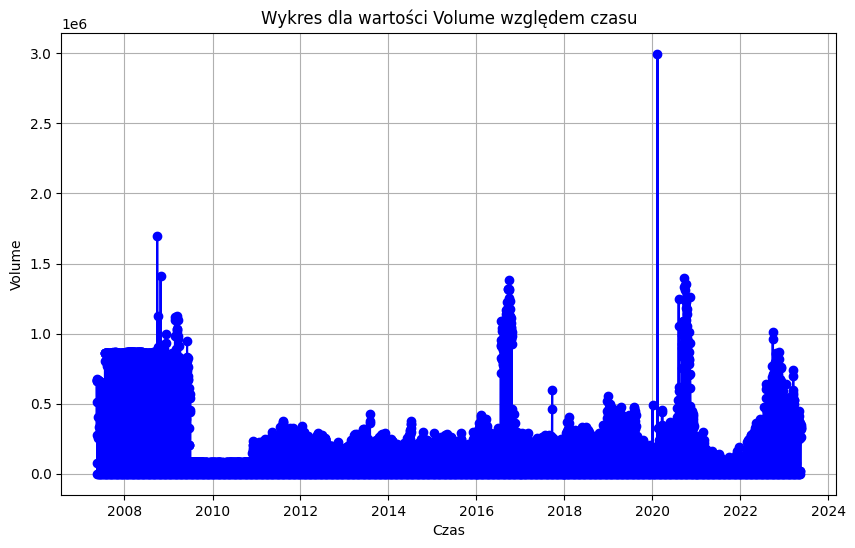

In [83]:
df = getDataPandas()
findMissingRecordsByWeekday(df,4)
print(df.drop(columns='WeekDay').describe())
print('------------------------------')
print(df.info())
print('------------------------------')
print(df.head(10))
print('------------------------------')
checkDataQuality(df)
plotValueOverTime(df,'Volume')

Brakujące rekordy dla dnia tygodnia 4:
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, WeekDay]
Index: []
              Open         High          Low        Close        Volume
count  5012.000000  5012.000000  5012.000000  5012.000000  5.012000e+03
mean      1.239466     1.244242     1.234896     1.239446  2.579277e+05
std       0.137320     0.138182     0.136441     0.137316  2.575953e+05
min       0.956940     0.967070     0.953570     0.956880  4.970000e+02
25%       1.121190     1.124775     1.118040     1.121220  8.103875e+04
50%       1.216825     1.220240     1.213460     1.216740  1.915135e+05
75%       1.350847     1.354922     1.345675     1.350245  2.829888e+05
max       1.597490     1.603890     1.587890     1.597490  2.997191e+06
------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5012 entries, 2007-05-14 to 2023-05-19
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   

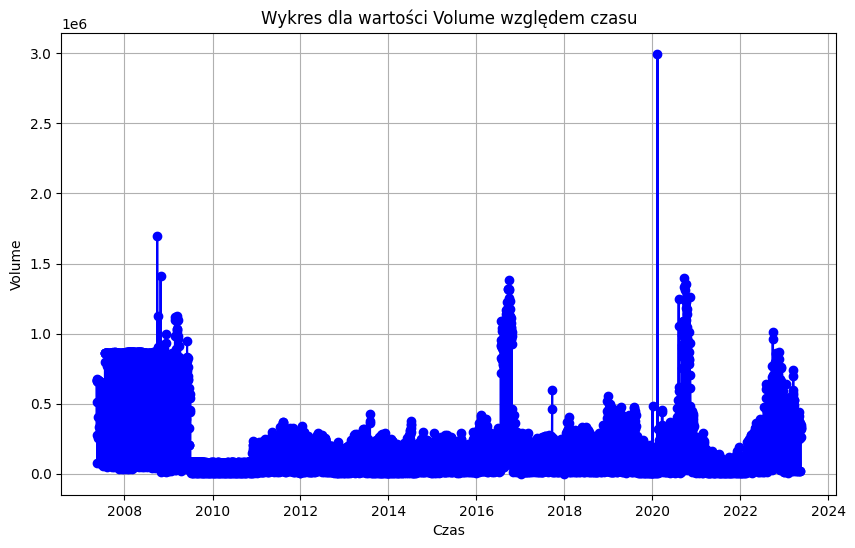

In [84]:
df = getDataPandas()
df = getNonZeroData(df)
findMissingRecordsByWeekday(df,4)
print(df.drop(columns='WeekDay').describe())
print('------------------------------')
print(df.info())
print('------------------------------')
print(df.head(10))
print('------------------------------')
checkDataQuality(df)
plotValueOverTime(df,'Volume')

Brakujące rekordy dla dnia tygodnia 4:
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, WeekDay]
Index: []
              Open         High          Low        Close        Volume
count  3344.000000  3344.000000  3344.000000  3344.000000  3.344000e+03
mean      1.239456     1.244876     1.234309     1.239463  3.101074e+05
std       0.137286     0.138227     0.136250     0.137210  2.626946e+05
min       0.956940     0.967070     0.953570     0.957230  4.421000e+03
25%       1.121733     1.126013     1.118100     1.121563  1.546342e+05
50%       1.216920     1.221410     1.213460     1.216885  2.180650e+05
75%       1.350923     1.355637     1.344842     1.350840  3.328572e+05
max       1.597490     1.603890     1.586430     1.597490  2.997191e+06
------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3344 entries, 2007-05-14 to 2023-05-18
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   

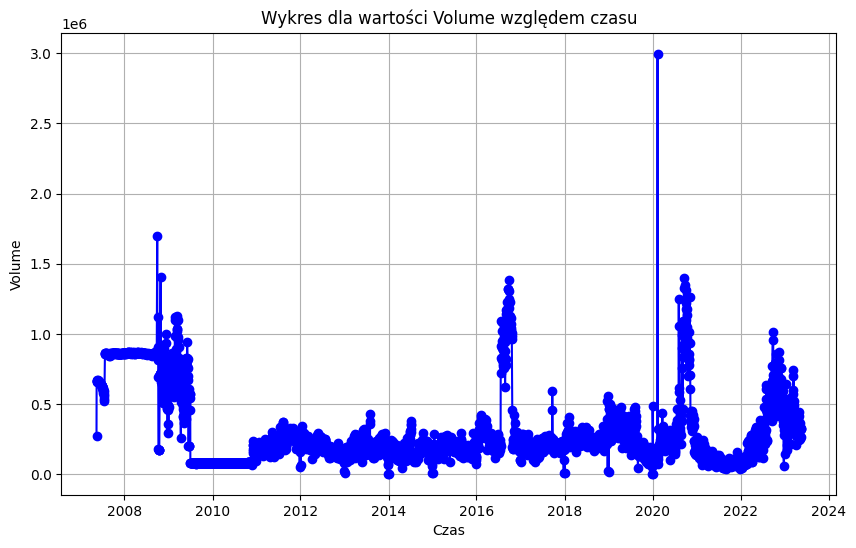

In [86]:
df = getDataPandas()
df = df.loc[df.index.weekday.isin([0,1,2,3])]
findMissingRecordsByWeekday(df,4)
print(df.drop(columns='WeekDay').describe())
print('------------------------------')
print(df.info())
print('------------------------------')
print(df.head(10))
print('------------------------------')
checkDataQuality(df)
plotValueOverTime(df,'Volume')

## Przykład 2 - Tworzenie obiektu DataFrame z obiektu Series

Przekształć obiekt quotations:

In [4]:
stocks = {
    'PLW': 387.00,
    'CDR': 339.5,
    'TEN': 349.5,
    '11B': 391.0,
    'BBT': 25.5,
    'F51': 19.2,
}
quotations = pd.Series(data=stocks)

do obiektu DataFrame. Zresetuj indeks i nazwij kolumny `ticker` oraz `price`. Wydrukuj obiekt DataFrame do konsoli.

### Rozwiązanie

In [5]:
stocks = {
    'PLW': 387.00,
    'CDR': 339.5,
    'TEN': 349.5,
    '11B': 391.0,
    'BBT': 25.5,
    'F51': 19.2,
}
quotations = pd.Series(data=stocks)
quotations = pd.DataFrame(quotations).reset_index()
quotations.columns = ['ticker', 'price']
print(quotations)

  ticker  price
0    PLW  387.0
1    CDR  339.5
2    TEN  349.5
3    11B  391.0
4    BBT   25.5
5    F51   19.2


## Przykład 3 - Tworzenie obiektu DataFrame i wypełnianie go danymi

Zbuduj obiekt DatetimeIndex zawierający daty w formacie `yyyy-mm-dd` dla wszystkich dni dla listopada 2023 roku i przypisz go do zmiennej date_range. Wydrukuj zawartość tej zmiennej do konsoli.

### Rozwiązanie - wariant 1

In [ ]:
date_range = pd.date_range(start='2023-11-01', periods=30)
print(date_range)

### Rozwiązanie - wariant 2

In [ ]:
date_range = pd.date_range(start='2023-11-01', end='2023-11-30')
print(date_range)

# Zadania do samodzielnego wykonania

## Ćwiczenie 1

Z podanego słownika:

In [6]:
stocks = {'PLW': 387.00, 'CDR': 339.5, 'TEN': 349.5, '11B': 391.0}

utwórz obiekt typu Series i przypisz do zmiennej quotations. Zawartość zmiennej quotations wydrukuj do konsoli.

### Miejsce na rozwiązanie

In [8]:
quotations = pd.Series(data=stocks)
print(quotations)

PLW    387.0
CDR    339.5
TEN    349.5
11B    391.0
dtype: float64


## Ćwiczenie 2

Podana jest zmienna quotations (obiekt typu Series):

In [ ]:
stocks = {'PLW': 387.00, 'CDR': 339.5, 'TEN': 349.5, '11B': 391.0}
quotations = pd.Series(data=stocks)

Przekształć obiekt quotations na listę. Wynik wydrukuj do konsoli.

### Miejsce na rozwiązanie

In [9]:
print(quotations.to_list())

[387.0, 339.5, 349.5, 391.0]


## Ćwiczenie 3

Przekształć obiekt quotations na obiekt typu DataFrame. Ustaw nazwę kolumny na price.

In [11]:
stocks = {'PLW': 387.00, 'CDR': 339.5, 'TEN': 349.5, '11B': 391.0}
quotations = pd.Series(data=stocks)

Wydrukuj wynik do konsoli.

### Miejsce na rozwiązanie

In [15]:
quotations = pd.DataFrame(data = quotations, columns=['ticker', 'price'])
print(quotations)

  ticker  price
0    PLW  387.0
1    CDR  339.5
2    TEN  349.5
3    11B  391.0


## Ćwiczenie 4

Używając bibliotek numpy i pandas zbuduj następujący obiekt Series:
    101    10.0
    102    20.0
    103    30.0
    104    40.0
    105    50.0
    106    60.0
    107    70.0
    108    80.0
    109    90.0
    dtype: float64

Wydrukuj wynik do konsoli.
Wskazówka: Użyj funkcji `np.arange()`.
### Miejsce na rozwiązanie

In [61]:
data = np.arange(10., 91., 10., dtype=float)
index = np.arange(101, 110, dtype=int)
quotations = pd.Series(data=data,index=index)
print(quotations)

101    10.0
102    20.0
103    30.0
104    40.0
105    50.0
106    60.0
107    70.0
108    80.0
109    90.0
dtype: float64


## Ćwiczenie 5

Podany jest następujący obiekt typu Series:

In [3]:
series = pd.Series(['001', '002', '003', '004'], list('abcd'))

Zmień typ danych obiektu na int. Wydrukuj wynik do konsoli.

### Miejsce na rozwiązanie

In [4]:
series = series.astype('int')
print(series)

a    1
b    2
c    3
d    4
dtype: int32


## Ćwiczenie 6

Podany jest następujący obiekt quotations:

In [63]:
stocks = {'PLW': 387.00, 'CDR': 339.5, 'TEN': 349.5, '11B': 391.0}
quotations = pd.Series(data=stocks)
print(quotations)

PLW    387.0
CDR    339.5
TEN    349.5
11B    391.0
dtype: float64


Dodaj do niego dwa elementy:
- klucz: BBT, wartość: 25.5
- klucz: F51, wartość: 19.2

Wydrukuj zawartość zmiennej quotations do konsoli.

### Miejsce na rozwiązanie

In [64]:
quotations['BBT'] = 25.5
quotations['F51'] = 19.2
print(quotations)

PLW    387.0
CDR    339.5
TEN    349.5
11B    391.0
BBT     25.5
F51     19.2
dtype: float64


## Ćwiczenie 7

Zbuduj poniższy obiekt DataFrame i przypisz go do zmiennej companies:
<img src="img/1.png">
    
Wydrukuj obiekt do konsoli.


### Miejsce na rozwiązanie

In [5]:
companies = pd.DataFrame(np.array([['Amazon', 'Microsoft', 'Facebook'], [2375.0, 178.6, 179.2], ['AMZU.US', 'MSFT.US', 'FB.US']]).T ,columns=['company', 'price', 'ticker'])
print(companies)

     company   price   ticker
0     Amazon  2375.0  AMZU.US
1  Microsoft   178.6  MSFT.US
2   Facebook   179.2    FB.US


## Ćwiczenie 8

Przekształć pierwszą kolumnę obiektu companies na indeks. Wydrukuj obiekt do konsoli.

In [80]:
data_dict = {
    'company': ['Amazon', 'Microsoft', 'Facebook'],
    'price': [2375.00, 178.6, 179.2],
    'ticker': ['AMZN.US', 'MSFT.US', 'FB.US']
}

companies = pd.DataFrame(data=data_dict)

### Miejsce na rozwiązanie

In [82]:
companies = companies.set_index('company')
print(companies)

            price   ticker
company                   
Amazon     2375.0  AMZN.US
Microsoft   178.6  MSFT.US
Facebook    179.2    FB.US


## Ćwiczenie 9

Zbuduj obiekt DatetimeIndex zawierający daty w formacie `yyyy-mm-dd` dla wszystkich dni dla stycznia 2020 roku i przypisz go do zmiennej date_range. Wydrukuj zawartość tej zmiennej do konsoli.

### Miejsce na rozwiązanie

In [44]:
# from datetime import date
# today = date.today()
date_range = pd.date_range(start='2020-01-01', end='2020-01-31')
print(date_range)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31'],
              dtype='datetime64[ns]', freq='D')


## Ćwiczenie 10

Zbuduj obiekt DatetimeIndex zawierający daty w formacie `yyyy-mm-dd` dla wszystkich poniedziałków z 2020 r. i przypisz go do zmiennej date_range. Wydrukuj zawartość tej zmiennej do konsoli.

### Miejsce na rozwiązanie

In [45]:
date_range = pd.date_range(start='2020-01-01', end='2020-01-31',freq="W-MON")
print(date_range)

DatetimeIndex(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27'], dtype='datetime64[ns]', freq='W-MON')


## Ćwiczenie 11

Zbuduj obiekt DatetimeIndex zawierający daty w formacie `yyyy-mm-dd hh: mm: ss` dla 1 stycznia 2021 roku z interwałem czasowym 1h i przypisz do zmiennej date_range. Wydrukuj zawartość tej zmiennej do konsoli.

### Miejsce na rozwiązanie

In [52]:
date_range = pd.date_range(start='2021-01-01 00:00:00', end='2021-01-01 23:59:59',freq="H")
print(date_range)

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               '2021-01-01 10:00:00', '2021-01-01 11:00:00',
               '2021-01-01 12:00:00', '2021-01-01 13:00:00',
               '2021-01-01 14:00:00', '2021-01-01 15:00:00',
               '2021-01-01 16:00:00', '2021-01-01 17:00:00',
               '2021-01-01 18:00:00', '2021-01-01 19:00:00',
               '2021-01-01 20:00:00', '2021-01-01 21:00:00',
               '2021-01-01 22:00:00', '2021-01-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')


## Ćwiczenie 12

Zbuduj obiekt DataFrame określony poniżej i wydrukuj do konsoli.
  -  Kolumna day ma zawierać daty od 1 marca 2023 roku do o 31 marca 2023 roku włącznie. 
  - Kolumna day_of_year to numer dnia w całym roku

### Miejsce na rozwiązanie

In [55]:
day = pd.date_range(start='2023-03-01', end='2023-03-31',freq="D")
day_of_year = day.day_of_year
dataFrame = pd.DataFrame({'day':day,'day_of_year':day_of_year})
print(dataFrame)

          day  day_of_year
0  2023-03-01           60
1  2023-03-02           61
2  2023-03-03           62
3  2023-03-04           63
4  2023-03-05           64
5  2023-03-06           65
6  2023-03-07           66
7  2023-03-08           67
8  2023-03-09           68
9  2023-03-10           69
10 2023-03-11           70
11 2023-03-12           71
12 2023-03-13           72
13 2023-03-14           73
14 2023-03-15           74
15 2023-03-16           75
16 2023-03-17           76
17 2023-03-18           77
18 2023-03-19           78
19 2023-03-20           79
20 2023-03-21           80
21 2023-03-22           81
22 2023-03-23           82
23 2023-03-24           83
24 2023-03-25           84
25 2023-03-26           85
26 2023-03-27           86
27 2023-03-28           87
28 2023-03-29           88
29 2023-03-30           89
30 2023-03-31           90


## Ćwiczenie 13

Podany jest następujący słownik data_dict:

In [56]:
data_dict = {
    'normal': np.random.normal(loc=0, scale=1, size=1000),
    'uniform': np.random.uniform(low=0, high=1, size=1000),
    'binomial': np.random.binomial(n=1, p=0.2, size=1000)
}

Zbuduj obiekt DateFrame z tego słownika. Dodatkowo jako indeks dodaj datę od 01.01.2023. Obiekt przypisz do zmiennej df. Wydrukuj zawartość zmiennej df do konsoli.

### Miejsce na rozwiązanie

In [68]:
df = pd.DataFrame(data_dict)
day = pd.date_range(start='2023-01-01', periods=1000,freq="D")
print(day)
df.index = day
print(df)

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2025-09-17', '2025-09-18', '2025-09-19', '2025-09-20',
               '2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24',
               '2025-09-25', '2025-09-26'],
              dtype='datetime64[ns]', length=1000, freq='D')
              normal   uniform  binomial
2023-01-01  0.003435  0.605525         0
2023-01-02 -2.469926  0.276617         0
2023-01-03 -0.078219  0.039728         0
2023-01-04  0.210007  0.262052         0
2023-01-05 -0.329299  0.154151         0
...              ...       ...       ...
2025-09-22  0.963499  0.056656         0
2025-09-23 -1.534106  0.194315         1
2025-09-24 -1.516038  0.574210         1
2025-09-25  2.522327  0.110657         0
2025-09-26 -1.476837  0.935417         0

[1000 rows x 3 columns]


## Ćwiczenie 14

Podany jest obiekt df. Wykonaj poniższe polecenia:
- wydrukuj pierwsze 10 wierszy tego obiektu,
- wydrukuj pustą linię,
- wydrukuj ostatnie 5 wierszy tego obiektu.

In [ ]:
data_dict = {
    'normal': np.random.normal(loc=0, scale=1, size=1000),
    'uniform': np.random.uniform(low=0, high=1, size=1000),
    'binomial': np.random.binomial(n=1, p=0.2, size=1000)
}

df = pd.DataFrame(data=data_dict, index=pd.date_range('2024-01-01', periods=1000))

### Miejsce na rozwiązanie

In [83]:
print(df.head(10))
print()
print(df.tail(5))

              normal   uniform  binomial
2023-01-01  0.003435  0.605525         0
2023-01-02 -2.469926  0.276617         0
2023-01-03 -0.078219  0.039728         0
2023-01-04  0.210007  0.262052         0
2023-01-05 -0.329299  0.154151         0
2023-01-06  1.051329  0.033853         0
2023-01-07  0.139328  0.356903         0
2023-01-08 -0.288102  0.589430         0
2023-01-09  0.649762  0.956088         0
2023-01-10 -0.631742  0.609382         0

              normal   uniform  binomial
2025-09-22  0.963499  0.056656         0
2025-09-23 -1.534106  0.194315         1
2025-09-24 -1.516038  0.574210         1
2025-09-25  2.522327  0.110657         0
2025-09-26 -1.476837  0.935417         0


## Ćwiczenie 15

Wyświetl podstawowe informacje o obiekcie df (liczba wierszy, liczba kolumn, typ zmiennych) wykorzystując metodę `pd.DataFrame.info()`, następnie wydrukuj pustą linię i wydrukuj podstawowe statystyki obiektu df (wartość średnia, odchylenie, min, max, mediana) za pomocą metody `pd.DataFrame.describe()`.

In [84]:
data_dict = {
    'normal': np.random.normal(loc=0, scale=1, size=1000),
    'uniform': np.random.uniform(low=0, high=1, size=1000),
    'binomial': np.random.binomial(n=1, p=0.2, size=1000)
}

df = pd.DataFrame(data=data_dict, index=pd.date_range('2023-01-01', periods=1000))

### Miejsce na rozwiązanie

In [85]:
print(df.info())
print()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-01-01 to 2025-09-26
Freq: D
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   normal    1000 non-null   float64
 1   uniform   1000 non-null   float64
 2   binomial  1000 non-null   int32  
dtypes: float64(2), int32(1)
memory usage: 27.3 KB
None

            normal      uniform     binomial
count  1000.000000  1000.000000  1000.000000
mean     -0.023490     0.496771     0.203000
std       0.992543     0.288250     0.402434
min      -2.968528     0.000014     0.000000
25%      -0.736432     0.258528     0.000000
50%       0.003725     0.484261     0.000000
75%       0.671296     0.756987     0.000000
max       2.771975     0.999673     1.000000


## Ćwiczenie 16

Znajdź rozkład wartości zmiennej binomial z obiektu DataFrame podanego poniżej. Wydrukuj wynik do konsoli.
Wskazówka: Użyj `pd.Series.value_counts()`.

In [86]:
data_dict = {
    'normal': np.random.normal(loc=0, scale=1, size=1000),
    'uniform': np.random.uniform(low=0, high=1, size=1000),
    'binomial': np.random.binomial(n=1, p=0.2, size=1000)
}

df = pd.DataFrame(data=data_dict, index=pd.date_range('2023-01-01', periods=1000))

### Miejsce na rozwiązanie

In [95]:
print(df['binomial'].value_counts())

binomial
0    808
1    192
Name: count, dtype: int64


## Ćwiczenie 17

Wyodrębnij pierwsze 50 rekordów z obiektu df i zapisz do pliku o nazwie `dataframe50.csv`.

In [90]:
data_dict = {
    'normal': np.random.normal(loc=0, scale=1, size=1000),
    'uniform': np.random.uniform(low=0, high=1, size=1000),
    'binomial': np.random.binomial(n=1, p=0.2, size=1000)
}

df = pd.DataFrame(data=data_dict, index=pd.date_range('2023-01-01', periods=1000))

### Miejsce na rozwiązanie

In [91]:
df.head(50).to_csv('dataframe50.csv')

## Ćwiczenie 18

Załaduj plik `dataframe50.csv` do zmiennej df_new (pamiętaj o prawidłowym załadowaniu indeksu) i wydrukuj zmienną df_new do konsoli.